# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$



## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Solution 1 


In [10]:
# Import necessary libraries
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum 

# Set the max number of iterations
N1 = 300 

# Given value of Delta t
delta_t = 0.01

# Gravity 
gravity = 9.81

# Tolerance for the algorithm
tol = 1e-4

# We don't want to print every decimal!
np.set_printoptions(suppress=True, precision=4) 


### Algorithm 

Given below are the steps to be followed to implement an SQP for the given model with only equality constraints 
#### 1. Reformulating the cost function
Given the cost function, $$\min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2$$ It appears similar to one for tracking a desired trajectory. So we shall reformulate it by expanding the term that depends on $\theta_n$ and ignore the constant terms. This leads us to the cost function, 
$\begin{equation} \notag \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10\theta_n^2 - 20\theta_n\pi + 0.1\omega_n^2 + 0.1u_n^2 \end{equation}$ OR
$ \begin{equation} \notag \min_{x} \sum_{n=0}^{300} \left( \frac{1}{2} x_n^T Q x_n -  x_{des}^T Q x_n \right) \end{equation} $ Where, 
$\begin{align}
    \notag &x_n = \begin{bmatrix} \theta_n \\  \omega_n \\ u_n\end{bmatrix} && Q = \begin{bmatrix} 20 & 0 & 0 \\ 0 & 0.2 & 0 \\ 0 & 0 & 0.2 \end{bmatrix} &&& x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix}
\end{align}$ 
Please note that the weight $R$ that is used to penalise the control input $u$ has been included inside of the $Q$ matrix, which is why it has not been explicity written in the above equation.

Rewriting this in matrix form and using the appropriate given terms, we get, 
$$\notag  \min_{\bar{x}} \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} $$
$\begin{align}
    \notag &\text{Where, } \quad \bar{x} = \begin{bmatrix} \bar{x}_0 \\ \bar{x}_1 \\ \bar{x}_2 \\ \vdots \end{bmatrix} &&G = \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix} &&&g^T = \begin{bmatrix} -x_{des}^T Q & -x_{des}^T Q & -x_{des}^T Q & \cdots \end{bmatrix} &&&&\text{with each} \quad \bar{x}_n = \begin{bmatrix} \bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n \end{bmatrix} \forall n \in \left[0, 300\right] \quad \text{and} \quad x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix}
\end{align}$

Using this logic, the function below is written to find the cost of a given guess

In [11]:
def cost_func(bar_x: np.ndarray, N=300):
    # Define the weighting matrix Q
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])

    # Define the desired state vector x_des
    x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

    # Construct the block diagonal matrix G with N copies of Q along the diagonal
    # Shape of G: (3*N, 3*N)
    G = block_diag(*([Q] * N))

    # Compute the vector g by repeating (Q @ x_des) N times
    # (Q @ x_des) results in a (3, 1) vector
    # After flattening and tiling, g has shape (3*N, 1)
    g = np.tile(-(Q @ x_des).flatten(), N).reshape(-1, 1)

    return ((0.5 * ((bar_x.T @ G) @ bar_x)) + (g.T @ bar_x))[0, 0]


#### 2. Reformulating the equality constraints
We have been given the constraints, 
$\begin{align}
\notag \theta_0 &= 0 \\
\notag \omega_0 &= 0 \\
\notag \theta_{n+1} &= \theta_n + \Delta t \ \omega_n \\
\notag \omega_{n+1} &= \omega_n + \Delta t\ (u_n - g \sin\theta_n)
\end{align}$

As we can see, one of the constraints is non-linear. So we must first find a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ where $\Delta x$ represents a small variation around $\bar{x}$. To do that, we shall perform the Taylor Expansion of the non-linear constraints around $\bar{x}$, which will be given by, 
$\begin{align} 
    \notag \Delta \theta_{n+1} &= \Delta \theta_{n} + \Delta t \Delta \omega_n \\
    \notag \Delta \omega_{n+1} &= \Delta \omega_{n} + \Delta t (\Delta u_n - g  \Delta \theta_n \cos \theta_n)
\end{align}$

Combining these constraints in the matrix form, we get,
$\begin{equation}\notag
    \begin{bmatrix} 1 & \Delta t & 0 & -1 & 0 & 0 \\ - \Delta t g \cos \bar{\theta_n} & 1 & \Delta t & 0 & -1 & 0 \end{bmatrix} \begin{bmatrix} \Delta \theta_n \\ \Delta \omega_n \\ \Delta u_n \\ \Delta \theta_{n+1} \\ \Delta \omega_{n+1} \\ \Delta u_{n+1} \end{bmatrix} = \begin{bmatrix} 0 \\ 0\end{bmatrix}
\end{equation}$

Now, we shall include the original, non-linear constraints to obtain, 
$\begin{equation}\notag
    \begin{bmatrix} 1 & \Delta t & 0 & -1 & 0 & 0 \\ - \Delta t g \cos \bar{\theta_n} & 1 & \Delta t & 0 & -1 & 0 \end{bmatrix} \begin{bmatrix} \Delta \theta_n \\ \Delta \omega_n \\ \Delta u_n \\ \Delta \theta_{n+1} \\ \Delta \omega_{n+1} \\ \Delta u_{n+1} \end{bmatrix} = \begin{bmatrix}  \theta_n + \Delta t \ \omega_n - \theta_{n+1} \\   \omega_n + \Delta t\ (u_n - g \sin\theta_n) - \omega_{n+1} \end{bmatrix}
\end{equation}$

Now, we shall include the linear constraints as well and stack all of them together to obtain sparse matrices $G(\bar{x})$ and $g(\bar{x})$, 

$\begin{align} 
    \notag G (\bar{x}) \Delta x &= g(\bar{x}) \\ 
    \notag \\  
    \notag \Rightarrow \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\ 1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots \\ - \Delta t g \cos \bar{\theta_0} & 1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & \cdots \\ 0 & 0 & 0 & 1 & \Delta t & 0 & -1 & 0 & 0 & \cdots \\ 0 & 0 & 0 & - \Delta t g \cos \bar{\theta_1} & 1 & \Delta t & 0 & -1 & 0 & \cdots \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots\end{bmatrix}  \begin{bmatrix} \Delta \theta_0 \\ \Delta \omega_0 \\ \Delta u_0 \\ \Delta \theta_1 \\ \Delta \omega_1 \\ \Delta u_1 \\ \Delta \theta_2 \\ \Delta \omega_2 \\ \Delta u_2 \\ \vdots  \end{bmatrix} &= \begin{bmatrix} 0 \\ 0 \\ \bar{\theta}_0 + \Delta t \ \bar{\omega}_0 - \bar{\theta}_1 \\   \bar{\omega}_0 + \Delta t\ (\bar{u}_0 - g \sin\bar{\theta}_0) - \bar{\omega}_1 \\ \bar{\theta}_1 + \Delta t \ \bar{\omega}_1 - \bar{\theta}_2 \\   \bar{\omega}_1 + \Delta t\ (\bar{u}_1 - g \sin\bar{\theta}_1) - \bar{\omega}_2 \\ \vdots \end{bmatrix}
\end{align}$

Based on this logic, the below function was written to compute the values of $G(\bar{x})$ and $g(\bar{x})$ with a given guess $\bar{x}$.

In [12]:
def compute_G_g(bar_x: np.ndarray, N=300):
    """
    Compute the Jacobian matrix G and the residual vector g for the linear approximation
    of the constraints in the Sequential Quadratic Programming (SQP) method.

    This function linearizes the nonlinear constraints of the pendulum optimal control problem
    around the current guess `bar_x`. The constraints include the initial conditions and
    the dynamic equations governing the pendulum's motion.

    Args:
        bar_x (np.ndarray): 
            Current guess of the state vector, structured as follows:
            [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N, omega_N]
            - theta_n: Angle of the pendulum at time step n
            - omega_n: Angular velocity at time step n
            - u_n: Control input at time step n
            The length of `bar_x` should be `3 * N`, where N is the number of time steps.

    Returns:
        G (np.ndarray): 
            Jacobian matrix of the constraints with respect to the variables.
            Shape: (2 * N + 2, 3 * N1)
            Each row corresponds to a constraint, and each column corresponds to a variable
            in `bar_x`. The matrix is structured to accommodate the initial conditions and
            the dynamic constraints for each time step.

        g (np.ndarray): 
            Residual vector of the constraints evaluated at `bar_x`.
            Shape: (2 * N1 + 2, 1)
            Each entry represents the negative of the constraint function evaluated at
            the current guess `bar_x`. This vector is used to form the linearized
            constraints in the SQP algorithm.
    """
    # Initialize the Jacobian matrix G as an identity matrix for the initial constraints
    # Shape: (2, 3 * N)
    G = np.eye(2, 3 * N)

    # Initialize the residual vector g with zeros for the initial constraints
    # Shape: (2, 1)
    g = np.zeros((2, 1), dtype=np.float64)

    # Set the first element of G corresponding to theta_0 = 0
    G[0, 0] = 1

    # Set the second element of G corresponding to omega_0 = 0
    G[1, 1] = 1

    # Loop over each time step to add dynamic constraints
    # The loop increments by 3 because variables are ordered as [theta, omega, u]
    for i in range(0, (N - 1) * 3, 3):
        # Extract the current state and control from bar_x
        bar_theta_i = bar_x[i]       # theta_n
        bar_omega_i = bar_x[i + 1]   # omega_n
        bar_u_i = bar_x[i + 2]       # u_n
        bar_theta_ip1 = bar_x[i + 3]  # theta_{n+1}
        bar_omega_ip1 = bar_x[i + 4]  # omega_{n+1}

        # Construct the Jacobian submatrix for the current dynamic constraints
        G_i = np.hstack((
            # Zeros for variables before the current time step
            np.zeros((2, (i // 3) * 3)),

            # Partial derivatives for the dynamic constraints at time step n
            np.array([
                [1, delta_t, 0, -1, 0, 0],  # Derivatives for theta constraint
                [
                    # Derivative w.r.t theta_n for omega constraint
                    -(delta_t * gravity * np.cos(bar_theta_i)[0]),
                    1,
                    delta_t,
                    0,
                    -1,
                    0
                ]  # Derivatives for omega constraint
            ], dtype=np.float64),

            # Zeros for variables after the current time step
            np.zeros((2, (N - 2 - (i // 3)) * 3))
        ))

        # Vertically stack the new constraints into the Jacobian matrix G
        G = np.vstack((G, G_i))

        # Compute the residuals for the current dynamic constraints
        g_i = np.vstack((
            [
                bar_theta_i + (delta_t * bar_omega_i) - bar_theta_ip1
            ],  # Residual for theta constraint: theta_n + delta_t * omega_n - theta_{n+1}
            [
                bar_omega_i + \
                (delta_t * (bar_u_i - (gravity * np.sin(bar_theta_i)))) - bar_omega_ip1
            ]  # Residual for omega constraint: omega_n + delta_t * (u_n - g*sin(theta_n)) - omega_{n+1}
        ))

        # Vertically stack the new residuals into the residual vector g
        g = np.vstack((g, g_i))

    return G, g

#### 3. Forming the Lagrangian
Now that we have the basic requirments for constrained optimisation with equality constraints, we shall form the Lagrangian as shown below 
$$ \mathcal{L}(x, \lambda) = f(x) + \lambda ^ T g(x) $$

Where, 
$$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} \quad \text{and} \quad g(\bar{x}) = G(\bar{x}) \Delta x$$
Please note that although the variables $G$ and $g$ are repeated, they have different meanings.

Using this, we can write the KKT Conditions to be, 
$\begin{align}
    \notag \nabla f(x) + \lambda \nabla g(x) &= 0 \\
    \notag g(x) &= 0
\end{align}$

And all terms have been defined in the previous steps. 

#### 4. Finding the gradient of the cost

Before we move on to solving the SQP, we need to do a couple of more steps, one of which is to find the gradient of the cost function, $$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x}$$ 

Let us recall that in lecture 2, a shortcut method was taught to find the gradient of a function. If a function is of the form, 
$\begin{align}
    \notag f(x) &= x^T P x + q^T x \\
    \notag \Rightarrow \nabla f(x) &= 2Px + q \\
    \notag \text{and} \quad \nabla ^2 f(x) &= 2 P
\end{align}$

By applying this trick to our equation, we can see that, 
$\begin{align}
\notag \nabla f(\bar{x}) &= 2 \cdot \frac{1}{2} G \bar{x} + g \\
\notag \Rightarrow \nabla f(\bar{x}) &= G \bar{x} + g \\
\end{align}$
$\begin{align}
    \notag &\text{Where, } \quad \bar{x} = \begin{bmatrix} \bar{x}_0 \\ \bar{x}_1 \\ \bar{x}_2 \\ \vdots \end{bmatrix} &&G = \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix} &&&g = \begin{bmatrix} (-x_{des}^T Q)^T \\ (-x_{des}^T Q)^T \\ (-x_{des}^T Q)^T \\ \vdots \end{bmatrix} &&&&\text{with each} \quad \bar{x}_n = \begin{bmatrix} \bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n \end{bmatrix} \forall n \in \left[0, 300\right] , \quad x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix} , \quad Q = \begin{bmatrix} 20 & 0 & 0 \\ 0 & 0.2 & 0 \\ 0 & 0 & 0.2 \end{bmatrix}
\end{align}$

The below function employs this logic to compute the gradient of the running cost.

In [13]:
def cost_grad(bar_x: np.ndarray, N=300):
    """
    Compute the gradient of the cost function for the optimal control problem.

    The cost function is defined as:
        f(x) = (1/2) * x^T * G * x + g^T * x
    where:
        - G is a block diagonal matrix with N copies of matrix Q along its diagonal.
        - g is a column vector where each 3-element block is (-x_des^T * Q)^T.

    This function calculates the gradient ∇f(x) = G * x + g.

    Args:
        bar_x (np.ndarray):
            Current guess of the state vector, structured as follows:
            [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N, omega_N]
            - theta_n: Angle of the pendulum at time step n
            - omega_n: Angular velocity at time step n
            - u_n: Control input at time step n
            The length of `bar_x` should be `3 * N`.

    Returns:
        np.ndarray:
            The gradient of the cost function evaluated at `bar_x`.
            Shape: (3 * N, 1)
            Each element corresponds to the partial derivative of the cost
            function with respect to the corresponding state variable in `bar_x`.
    """
    # Define the weighting matrix Q
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])

    # Define the desired state vector x_des
    x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

    # Construct the block diagonal matrix G with N copies of Q along the diagonal
    # Shape of G: (3*N, 3*N)
    G = block_diag(*([Q] * N))

    # Compute the vector g by repeating (Q @ x_des) N times
    # (Q @ x_des) results in a (3, 1) vector
    # After flattening and tiling, g has shape (3*N, 1)
    g = np.tile(-(Q @ x_des).flatten(), N).reshape(-1, 1)

    # Compute and return the gradient of the cost function: ∇f(x) = G * bar_x + g
    # bar_x is expected to be a (3*N, 1) vector
    return ((G @ bar_x) + g)

#### 5. Finding the hessian of the Lagrangian

This is the final step before solving the QP. We shall find the hessian of the Lagrangian formulated as, 
$$ \mathcal{L}(x, \lambda) = f(x) + \lambda ^ T g(x) $$

Where, 
$$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} \quad \text{and} \quad g(\bar{x}) = G(\bar{x}) \Delta x$$

Please note that although the variables $G$ and $g$ are repeated, they have different meanings.

The hessian of the Lagrangian will be given by, 
$$ \nabla ^2 \mathcal{L} (x, \lambda) = \begin{bmatrix} \frac{\partial ^2 \mathcal{L}}{\partial x^2} & \frac{\partial ^2 \mathcal{L}}{\partial x \partial \lambda} \\ \frac{\partial ^2 \mathcal{L}}{\partial \lambda \partial x} & \frac{\partial ^2 \mathcal{L}}{\partial \lambda ^2}\end{bmatrix}$$

Here, we must ignore the second order derivatives of the constraints. This results in the Hessian of the Lagrangian becoming, 
$$ \nabla ^2 \mathcal{L} (x, \lambda) \approx  \nabla_{xx} ^2 \mathcal{L} (x)$$

Applying the same shortcut method to find the gradient and hessian, we can find that, 
$$ \nabla_{xx} ^2 \mathcal{L} (x) = 2 \cdot \frac{1}{2} \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix}  $$

We shall use this logic to write the function for this computation, as shown below.

In [14]:
def compute_hessian_L(N=300):
    """Function to compute the hessian of the lagrangian, ignoring second order derivatives of the constraints

    Returns:
        np.ndarray: Hessian of the lagrangian
    """
    return block_diag(*([np.array([[20, 0, 0], [0, 0.2, 0], [0, 0, 0.2]])] * N))

#### 6. Solving the KKT System
Now that we have obtained all the prerequsites for forming the KKT System of equations, we shall now have to solve the QP, 
$$
\begin{equation}
\begin{aligned}
    \notag & \min_{p} \frac{1}{2} p^T \nabla_{xx}^2 \mathcal{L}(x_k) p + p^T \nabla f(x_k) \\
    \notag  & \text{subject to } \nabla g(x_k)^T p + g(x_k) = 0
\end{aligned}
\end{equation}$$ 

Which is the same as solving

$$\begin{equation}\notag 
    \begin{bmatrix} 
        \nabla^2_{xx} \mathcal{L}(x_k) & \nabla g(x_k) ^T \\
        \nabla g(x_k) & 0 
    \end{bmatrix}
    \begin{pmatrix} 
        p_k \\ 
        \lambda_{k+1} 
    \end{pmatrix} 
    = 
    \begin{pmatrix} 
        -\nabla f(x_k) \\ 
        -g(x_k) 
    \end{pmatrix}
\end{equation}$$

Where $\nabla g(x_k) $ is the Jacobian we computed earlier, when we linearised the constraints.

The below function was written based on this logic.

In [15]:
def solve_KKT_eq_constr(bar_x: np.ndarray):
    """
    Solves the Karush-Kuhn-Tucker (KKT) system for the current guess of variables in the SQP algorithm.

    This function constructs and solves the KKT system to obtain the search direction for the variables
    and the updated Lagrange multipliers based on the current guess `bar_x`.

    Parameters:
    ----------
    bar_x : np.ndarray
        Current guess of the optimization variables, structured as
        [θ₀, ω₀, u₀, θ₁, ω₁, u₁, ..., θₙ, ωₙ, uₙ]^T,
        where θ is the angle, ω is the angular velocity, and u is the control input at each time step.

    Returns:
    -------
    pk : np.ndarray
        Search direction for the optimization variables. This vector indicates how to update `bar_x` to move towards the optimum.

    lambda_kp1 : np.ndarray
        Updated Lagrange multipliers corresponding to the constraints. These multipliers provide sensitivity information about the constraints.
    """
    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    lag_hess_mat = compute_hessian_L()

    # Compute the Jacobian matrix of the constraints and the constant term
    # G(x) represents the Jacobian of the constraints evaluated at the current guess `bar_x`
    # g(x) represents the residual of the constraints evaluated at the current guess `bar_x`
    const_jac_mat, const_mat = compute_G_g(bar_x=bar_x)

    # Compute the gradient of the cost function with respect to the optimization variables at `bar_x`
    cost_grad_mat = cost_grad(bar_x)

    # Assemble the left-hand side (LHS) of the KKT system
    # The LHS matrix is a block matrix composed of the Hessian of the Lagrangian and the constraint Jacobian
    LHS = np.block([
        [lag_hess_mat, const_jac_mat.T],
        [const_jac_mat, np.zeros(
            (const_jac_mat.shape[0], const_jac_mat.shape[0]))]
    ])

    # Assemble the right-hand side (RHS) of the KKT system
    # The RHS vector combines the negative gradient of the cost and the negative constraint residuals
    RHS = np.vstack((-cost_grad_mat, -const_mat))

    # Solve the KKT system to obtain the search direction `pk` and the updated Lagrange multipliers `lambda_kp1`
    res = np.linalg.solve(LHS, RHS)

    # Extract the search direction for the optimization variables from the solution
    # Assumes that the first 3*N elements correspond to `pk`
    pk = res[:3*N1, 0]

    # Extract the updated Lagrange multipliers from the solution
    # Assumes that the remaining elements correspond to `lambda_kp1`
    lambda_kp1 = res[3*N1:, 0]

    return pk, lambda_kp1

#### 7. Total constraint violation

Now, we need to write a function to find the total constraint violation. This would just be the sum of all the rows of $g(x)$.

In [16]:
import numpy as np


def tot_constraint_violation_eq(bar_x: np.ndarray):
    """
    Computes the total constraint violation for the current guess of optimization variables.

    This function calculates the sum of the absolute values of all constraint residuals
    evaluated at the current guess `bar_x`. It provides a measure of how much the current
    solution violates the constraints, which is useful for assessing feasibility and
    convergence in the SQP algorithm.

    Parameters
    ----------
    bar_x : np.ndarray
        Current guess of the optimization variables, structured as
        [θ₀, ω₀, u₀, θ₁, ω₁, u₁, ..., θₙ, ωₙ, uₙ]^T,
        where θ is the angle, ω is the angular velocity, and u is the control input at each time step.

    Returns
    -------
    float
        The total constraint violation, calculated as the absolute sum of all constraint residuals.
    """
    # Compute the Jacobian matrix of the constraints and the constraint residuals at `bar_x`
    _, g = compute_G_g(bar_x)

    # Calculate the total constraint violation by summing the absolute values of the residuals
    total_violation = np.sum(abs(g))

    return total_violation

#### 8. Filter Line search

Now that we have a value of $\bar{x}$, the next thing to do is perform line search to compute $\alpha$. We shall use the total constraint violation function for this purpose. 

In [19]:
x_guess = np.zeros((3*N1, 1))
# lambda_guess = np.zeros(((2 + (2*N)), 1))
alpha = 1
rho = 0.5
c_best = np.inf
cost_best = np.inf
cost_history = []
alpha_history = []
c_history = []
for i in range(0, N1):
    pk, _ = solve_KKT_eq_constr(x_guess)
    pk = pk.reshape(900, 1)
    while ((cost_func((x_guess + (alpha * pk))) > cost_best) & (tot_constraint_violation_eq((x_guess + (alpha * pk))) > c_best)):
        alpha = rho * alpha
    c_best = tot_constraint_violation_eq((x_guess + (alpha * pk)))
    cost_best = cost_func((x_guess + (alpha * pk)))
    alpha_history.append(alpha)
    c_history.append(c_best)
    cost_history.append(cost_best)
    print(
        f"Current Cost = {cost_best}  Current Constraint Violation = {c_best}")
    x_guess = x_guess + (alpha * pk)
    if (c_best < tol):
        break
    # lambda_guess = lambda_guess + (alpha*pk)
print(f"Total iterations needed = {i+1}")
theta = x_guess[0::3].T
omega = x_guess[1::3].T
controls = x_guess[2::3].T

print("DEBUG POINT")

Current Cost = -14927.77942661906  Current Constraint Violation = 21.574083537716163
Current Cost = -23828.810833427106  Current Constraint Violation = 17.887520840583186
Current Cost = -24926.232488744557  Current Constraint Violation = 0.06013749482398708
Current Cost = -24926.596929091244  Current Constraint Violation = 4.657671887809084e-06
Total iterations needed = 4
DEBUG POINT


In [18]:
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, controls)

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpevyq6imt/temp.m4v']' returned non-zero exit status 255.

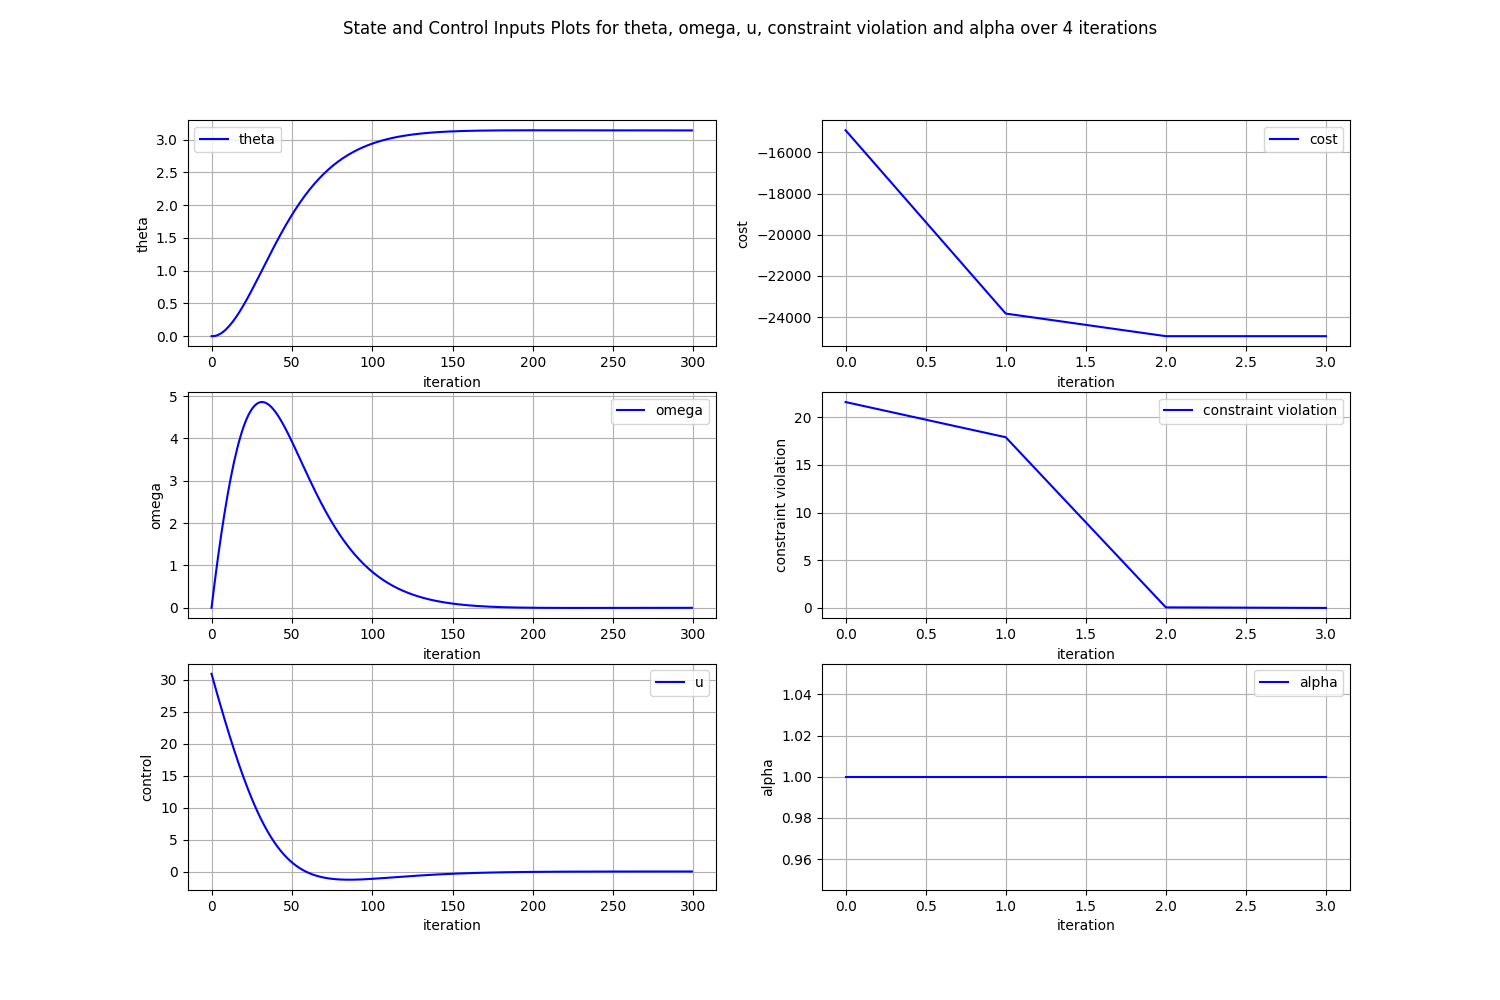

In [41]:
x_figsize = 15
y_figsize = 10
# Create a time array based on the number of columns in x1 or x2
time = np.arange(theta.shape[1])

# Create a single figure with a 3-row, 2-column layout
fig, axs = plt.subplots(3, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(
    f"State and Control Inputs Plots for theta, omega, u, constraint violation and alpha over {i+1} iterations")

# Plot theta
axs[0, 0].plot(time, theta[0, :], label='theta', color='blue')
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('theta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot omega
axs[1, 0].plot(time, omega[0, :], label='omega', color='blue')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('omega')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot u
axs[2, 0].plot(time, controls[0, :], label='u', color='blue')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('control')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot cost
axs[0, 1].plot(cost_history, label='cost', color='blue')
axs[0, 1].set_xlabel('iteration')
axs[0, 1].set_ylabel('cost')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot constraint violation
axs[1, 1].plot(c_history, label='constraint violation', color='blue')
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('constraint violation')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot alpha
axs[2, 1].plot(alpha_history, label='alpha', color='blue')
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('alpha')
axs[2, 1].legend()
axs[2, 1].grid(True)

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [42]:
# %matplotlib widget

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.animation as animation
# import IPython

# from qpsolvers import solve_qp, Problem, solve_problem

# import pendulum

# Set the max number of iterations
N2 = 500

In [43]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
# N = 300
controls = np.zeros((N2, 1))
x_init = np.array([[1.0], [0.]])
pendulum.animate_robot(x_init, controls.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAdhNtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Dx9liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI9z6B9hJKucXbnulv0Tx3pgWGkq4zCJoUSDQbMTKpHP
1+uP9z8QZom84f5DU6BeXVvtHm4djF23BlQKdhX2EUStmmG6N08XGoAVuMW72rKKVN6VdHRgsHNr
x3MR4qDMgAxERdUoQ7BXRJr4BX5soPZq/wcjolq6sTi1OvLDBtyBLPszN6tiPcUaMheYx0iV67aE
zZf/BUqm/lhAt8bzKYdsJ9/lcztqCxibPrNj5oyGn3C0REKARQj2zVOcjGQ+FMzZO2661ZGQyDFz
iir12w0bCCrErPPWnwawwtU4EcDyMcfy1O9nup++LMTj/9v5cGKwseLrqDKDLRy72SeWx0X1PS2r
gB5EoiitXz2syX3fZtL7eXGNp9LGfmQZvNn/8kQNYLyikrHwFtnL/NwLzzF1wqLYpRm7lnQcAK08
DUly7RKGunCX7cfEaLO2YI9VVl+nEQ2TqljRHoLZQNFsTQaOP2j4XG3YVytCbVbGIVASp/oAF//C
akP9qPwHBSjbB7Vl1PzegCEE2WGcj6HcMQiBVCgqScX7ZGCN7Zmpw1NB3YCxQiiE8wL1YVsNmsYO
OzTCcB1dAQrunxz+XTX/soaN28JssW843JkHpaZYMvll6F5RLvkCJmjRbb2sPWkcdKrr049Kyx0y
79yNR4wKycFmNozOSusbiujAOLdF+1YGixy4v91128C64QywR9ROS1PdihlQ5EsFxq/J9Yoc9iF3
UCuzDfjEBclfDEzkue5Ah47bQk6pa55v9JCKZmOg+HuqtJCWNdZB4hpBtGP95iFkbRtWQQTxUt4n
som/TaoCxzrc+Z4aIsma8+MyXGgaBgR5HVvzA3fpSnOia1FABYUU2rnBJdXAp9O7LU0Ypyx4czuq
WZFlPoFpwLpMmDVxo7sHgsR6rqKNbhawN/G/6zPVVLQmsHcPOM6PB9smQpgsGgDxgnQsPoilauVz
0PzsN5lNeoRnkCKNHH4APkFrP7Y1AUIkKNHJxg6lK6S3GY6WPJbeOtt3uwZe+EqMc76a15MoXOcf
cLj/qcfzADevR/eJisxU8oAjEFXCgGOHAYkhLNLWrCiRRw3eVRU9mQsjkHcx9bj7iL61v2mEENkI
JWnigX0Wid87/KfaVRy/YfdZgdi9/sl8U+AtFNd/qqSqAU9qsXfZpt9OlpnL5/9vx8kr2fVvRBUl
RYZQZZKeD0oh/lIJecwNx/ncXlEfLnOlCPzwzA6i+tlh5nEEAzGsd8RqlTXAhcMZ9fhD/cpfQ5Gl
9pj3DQJt8W0YUCJ/4o+QltdsRxCPVpc0Z3UZqOxUfnGSLoZ+G3A8qfFwhlOHAAl1NF6RVy13cn09
tT4H17QkXW9DX44NFszXEAHzGxKyE+jFMZXVmxDR2cFgdiXNiw7zfp1tcybZVsYdC4bXAehdmGBJ
IjzOUjnaYVUdL1mo6LixvKYYmr8VNead+mwz0UOSzM96Vl07rRMq1v5tCg4HSZz2zOKjA4S+BXPD
Q2wiIO87HTs4QrVOYUwEjH7/R6aZdr83y0uw8hwTd27X8R+WGoJcmIJ4d7r2GqNicXuMW//huBeH
J15j6MqA0cV9hl5qX8x41liORWI3os0bXDmtjZ6NwcCrMgVMV2E2RB7XF9EclND5J/q2Vnb6MiQG
xb8ZcsjwxS7juReW6xGPaPXb9Fmq3WJbj3g7Tih0kPgIFFeBHwoC4A7VvW7ivRXvjl/wiyT3QrEq
QQYBDxdv/R6vBF61VJGgzEcJlfp4xND1uyyRUc222gkttBj4ikMPVWvXx5iSAvhM+lkOgoaiB7cx
iCm49XPRD7CoR75XfE7+V3Sum2whtGCAo9qq9/yad3TEEkxvgTjvOh1RlNV29BeuY3OhmNHIyn25
hKYnwkK7zRnCGsiP4ii3Brm0iaKVTe+10WS6tFXBh6TAP6kDyGSoru3pNORoTfOiGv3UJfWnDIOy
x/gziqkHG7MvBV8+k3Dj20jf87ozfu1X5O1JlCCQ830nOQ2nFIoHPLkKwQEe7d0aSTFD5H/SIkH+
4ud6nhLSXdEonCTJ1WxkiFbkPJW2BcBOgSyfZDUxoTjL9Wx7RKkCQyH6hFcALN6HmhMrhVJ+6cAU
T7BvRtFl+NTOWWOC5+erQcx0wVmBDS/meofCCY81Z6QYONpUUkv9WkGrKY2H5+HbSZ14aL3NF7fE
EV+8S83Vh3d9Ztb/uwOz9

## Solution 2

### Algorithm - Additions and Changes

#### 9. Handling Inequality Constraints

An additional constraint of $$-4 \leq u_n \leq 4$$ has been given to us. So, we can apply it to the state vector as shown below, 

$$\begin{bmatrix} 0 \\ 0 \\ -4 \end{bmatrix} \leq \begin{bmatrix} \bar{\theta_n} \\ \bar{\omega_n} \\ \bar{u_n} \end{bmatrix} \leq \begin{bmatrix} 0 \\ 0 \\ 4 \end{bmatrix}$$

But this constraint will never allow the $\theta$ and $\omega$ of the pendulum to go beyond 0. In order to allow this to happen, we shall constrain the $\theta$ and $\omega$ as, 
$\begin{align} 
    \notag 0 \leq \bar{\theta}_n \leq \pi \\
    \notag -0.004 \leq \bar{\omega}_n \leq 5 
\end{align}$
The constraints for $\omega$ have been chosen based on the maximum and minimum values of all the $\omega$ 's computed in the previous part, where we optimised the cost with equality constraints.

Upon including these constraints within the above inequality, we get, 
$$\begin{bmatrix} 0 \\ -0.004 \\ -4 \end{bmatrix} \leq \begin{bmatrix} \bar{\theta_n} \\ \bar{\omega_n} \\ \bar{u_n} \end{bmatrix} \leq \begin{bmatrix} \pi \\ 5 \\ 4 \end{bmatrix}$$

In [49]:
def form_ineq_const():
    H = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, -1],
        [0, 0, 1]
    ], dtype=np.float64)
    H = block_diag(*([H] * N2))

    h = np.array([
        [0],
        [0],
        [0],
        [0],
        [4],
        [4]
    ], dtype=np.float64)
    h = np.tile(h, (N2, 1))
    return H, h


form_ineq_const()

(array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0, -1],
        [ 0,  0,  0, ...,  0,  0,  1]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [4],
        [4]]))

In [50]:
def solve_KKT_eq_ineq_constr(bar_x: np.ndarray):
    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    lag_hess_mat = compute_hessian_L(N=N2)

    # Compute the Jacobian matrix of the constraints and the constant term
    # G(x) represents the Jacobian of the constraints evaluated at the current guess `bar_x`
    # g(x) represents the residual of the constraints evaluated at the current guess `bar_x`
    const_jac_mat, const_mat = compute_G_g(bar_x=bar_x, N=N2)

    # Compute the gradient of the cost function with respect to the optimization variables at `bar_x`
    cost_grad_mat = cost_grad(bar_x, N=N2)

    # Assemble the left-hand side (LHS) of the KKT system
    # The LHS matrix is a block matrix composed of the Hessian of the Lagrangian and the constraint Jacobian
    # LHS = np.block([
    #     [lag_hess_mat, const_jac_mat.T],
    #     [const_jac_mat, np.zeros(
    #         (const_jac_mat.shape[0], const_jac_mat.shape[0]))]
    # ])

    # Assemble the right-hand side (RHS) of the KKT system
    # The RHS vector combines the negative gradient of the cost and the negative constraint residuals
    # RHS = np.vstack((-cost_grad_mat, -const_mat))
    lb = -np.inf * np.ones(3 * N2)
    ub = np.inf * np.ones(3 * N2)
    problem = Problem(P=lag_hess_mat, q=cost_grad_mat,
                      A=const_jac_mat, b=-const_mat, lb=lb, ub=ub, G=form_ineq_const()[0], h=form_ineq_const()[1])

    # problem = Problem(P=lag_hess_mat, q=cost_grad_mat,
    #                   A=const_jac_mat, b=-const_mat, G=form_ineq_const()[0], h=form_ineq_const()[1])
    # Solve the KKT system to obtain the search direction `pk` and the updated Lagrange multipliers `lambda_kp1`
    solution = solve_problem(problem, solver="cvxopt")

    # print(f"Primal: x = {solution.x}")
    # print(f"Dual (Gx <= h): z = {solution.z}")
    # print(f"Dual (Ax == b): y = {solution.y}")
    # print(f"Dual (lb <= x <= ub): z_box = {solution.z_box}")

    # return solution.x, solution.y, solution.z_box
    return solution

    # return solve_qp(P=lag_hess_mat, q=cost_grad_mat, A=const_jac_mat, b=-const_mat, lb=lb, ub=ub, solver='cvxopt', verbose=True, return_dual=True)

In [51]:
def tot_constraint_violation_eq_ineq(bar_x: np.ndarray):
    constraint_violation_eq = tot_constraint_violation_eq(bar_x)
    u_vals = abs(bar_x[2::3].flatten())
    constraint_violation_ineq = 0
    for u in u_vals:
        if abs(u) > 4:
            constraint_violation_ineq += (abs(u) - 4)
    return constraint_violation_eq + constraint_violation_ineq

In [54]:
def merit_function_eq_ineq(bar_x: np.ndarray, N=500, mu=1e-5):
    return cost_func(bar_x, N=N) + mu * tot_constraint_violation_eq_ineq(bar_x)

In [55]:
from IPython.display import clear_output
from time import sleep
x_init = np.array([theta[:, 0], omega[:, 0]])
x_guess = np.zeros((3*N2, 1))
# lambda_guess = np.zeros(((2 + (2*N)), 1))
alpha = 1.0
rho = 0.5
eta = 1e-4
c_best = np.inf
cost_best = np.inf
cost_history = []
alpha_history = []
c_history = []
for i in range(0, N2):
    solution = solve_KKT_eq_ineq_constr(x_guess)
    pk = solution.x.reshape(3*N2, 1)
    merit_current = merit_function_eq_ineq(x_guess)
    x_new = x_guess + alpha * pk
    merit_new = merit_function_eq_ineq(x_new)
    c_best = tot_constraint_violation_eq_ineq((x_guess + (alpha * pk)))
    cost_best = cost_func((x_guess + (alpha * pk)), N=N2)
    alpha_history.append(alpha)
    c_history.append(c_best)
    cost_history.append(cost_best)
    print(
        f"Current Cost = {cost_best}  Current Constraint Violation = {c_best}   Current alpha = {alpha}")

    while merit_new > merit_current + eta * alpha * np.dot(cost_grad(x_guess, N2).flatten(), pk.flatten()):
        alpha *= rho
        if alpha < 1e-8:
            print("Line search failed to find a suitable step size.")
            break
    x_guess = x_new
    controls = x_guess[2::3].T
    pendulum.animate_robot(x_init, controls)
    clear_output(wait=True)
    sleep(5)
    if (c_best < tol):
        break
    # lambda_guess = lambda_guess + (alpha*pk)
print(f"Total iterations needed = {i+1}")
theta = x_guess[0::3].T
omega = x_guess[1::3].T
controls = x_guess[2::3].T

print("DEBUG POINT")

KeyboardInterrupt: 

In [ ]:
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, controls)

In [57]:
# Import necessary libraries
import numpy as np
from scipy.linalg import block_diag
from qpsolvers import Problem, solve_problem
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

# Parameters
N2 = 300  # Number of time steps
delta_t = 0.01
gravity = 9.81
tol = 1e-4

# Control input bounds
u_max = 4.0
u_min = -4.0

# Initialize initial state (assuming theta and omega are defined elsewhere)
# Example initialization:
theta_initial = 0.0  # Starting angle in radians
omega_initial = 0.0  # Starting angular velocity in rad/s
x_init = np.array([theta_initial, omega_initial])

# Cost function


def cost_func(bar_x: np.ndarray, N: int):
    """
    Computes the cost function for the optimization problem.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        float: Cost value.
    """
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])
    x_des = np.array([np.pi, 0, 0]).reshape((3, 1))  # Desired state
    G = block_diag(*([Q] * N))
    g = np.tile(-(Q @ x_des).flatten(), N).reshape(-1, 1)
    return (0.5 * (bar_x.T @ G @ bar_x) + (g.T @ bar_x))[0, 0]

# Compute equality constraints (dynamics and initial conditions)


def compute_G_g(bar_x: np.ndarray, N: int):
    """
    Computes the Jacobian matrix and residuals for equality constraints.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        G_eq (ndarray): Jacobian matrix for equality constraints.
        g_eq (ndarray): Residual vector for equality constraints.
    """
    # Initialize Jacobian with initial conditions
    G_eq = np.zeros((2, 3 * N))
    G_eq[0, 0] = 1  # theta_0 = theta_initial
    G_eq[1, 1] = 1  # omega_0 = omega_initial

    # Initialize residuals with initial conditions
    g_eq = np.array([[bar_x[0, 0] - theta_initial],
                    [bar_x[1, 0] - omega_initial]])

    # Dynamics constraints
    for i in range(N - 1):
        theta_n = 3 * i
        omega_n = 3 * i + 1
        u_n = 3 * i + 2
        theta_np1 = 3 * (i + 1)
        omega_np1 = 3 * (i + 1) + 1

        # Construct G_i for dynamics constraints
        G_i = np.zeros((2, 3 * N))
        # Theta update: theta_np1 = theta_n + delta_t * omega_n
        G_i[0, theta_n] = 1
        G_i[0, omega_n] = delta_t
        G_i[0, theta_np1] = -1
        # Omega update: omega_np1 = omega_n + delta_t * (u_n - gravity * sin(theta_n))
        G_i[1, theta_n] = -delta_t * gravity * np.cos(bar_x[theta_n, 0])
        G_i[1, omega_n] = 1
        G_i[1, u_n] = delta_t
        G_i[1, omega_np1] = -1

        # Append to G_eq
        G_eq = np.vstack([G_eq, G_i])

        # Compute residuals for dynamics constraints
        g_theta = bar_x[theta_n, 0] + delta_t * \
            bar_x[omega_n, 0] - bar_x[theta_np1, 0]
        g_omega = bar_x[omega_n, 0] + delta_t * \
            (bar_x[u_n, 0] - gravity * np.sin(bar_x[theta_n, 0])) - \
            bar_x[omega_np1, 0]
        g_eq = np.vstack([g_eq, [[g_theta], [g_omega]]])

    return G_eq, g_eq

# Compute cost gradient


def cost_grad(bar_x: np.ndarray, N: int):
    """
    Computes the gradient of the cost function.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        ndarray: Gradient vector of shape (3*N,).
    """
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])
    x_des = np.array([np.pi, 0, 0]).reshape((3, 1))  # Desired state
    G = block_diag(*([Q] * N))
    g = np.tile(-(Q @ x_des).flatten(), N).reshape(-1, 1)
    return (G @ bar_x + g).flatten()

# Compute Hessian of the Lagrangian


def compute_hessian_L(N: int):
    """
    Computes the Hessian matrix of the Lagrangian.

    Args:
        N (int): Number of time steps.

    Returns:
        ndarray: Hessian matrix of shape (3*N, 3*N).
    """
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])
    return block_diag(*([Q] * N))

# Form inequality constraints (only u_n bounds)


def form_ineq_const(N: int):
    """
    Defines inequality constraints for control inputs u_n:
        -4 <= u_n <= 4 for each control input across all time steps.

    Args:
        N (int): Number of time steps.

    Returns:
        G_u (ndarray): Inequality constraint matrix of shape (2*N, 3*N).
        h_u (ndarray): Inequality constraint bounds of shape (2*N, 1).
    """
    # Control input bounds: -4 <= u_n <= 4
    # Represented as:
    #  -u_n <= 4  => u_n >= -4
    #   u_n <= 4
    G_u = np.array([
        [0, 0, -1],  # -u_n <= 4
        [0, 0, 1]    # u_n <= 4
    ])

    # Repeat the constraints for each time step
    G_u = block_diag(*([G_u] * N))

    # Bounds for each constraint
    h_u = np.tile(np.array([[4.0], [4.0]]), (N, 1))

    return G_u, h_u

# Compute constraint gradients (equality + inequality)


def compute_constraint_gradient(bar_x: np.ndarray, N: int):
    """
    Computes the combined Jacobian matrix for all constraints.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        G_total (ndarray): Combined Jacobian matrix for equality and inequality constraints.
    """
    G_eq, _ = compute_G_g(bar_x, N)
    G_ineq, _ = form_ineq_const(N)
    G_total = np.vstack([G_eq, G_ineq])
    return G_total

# Solve QP subproblem


def solve_KKT_eq_ineq_constr(bar_x: np.ndarray, N: int):
    """
    Solves the QP subproblem to find the step direction p.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        ndarray: Step direction vector p of shape (3*N, 1).
    """
    # Compute the Hessian matrix of the Lagrangian
    lag_hess_mat = compute_hessian_L(N=N)
    lag_hess_mat = (lag_hess_mat + lag_hess_mat.T) / 2  # Ensure symmetry

    # Compute the Jacobian matrix of the constraints and the residuals
    G_eq, g_eq = compute_G_g(bar_x=bar_x, N=N)
    G_ineq, h_ineq = form_ineq_const(N)

    # Equality constraints: A p + g(x) = 0
    A = G_eq
    b = -g_eq.flatten()

    # Inequality constraints: G_ineq p <= h_ineq
    G = G_ineq
    h = h_ineq.flatten()

    # Compute the gradient of the cost function
    cost_grad_mat = cost_grad(bar_x, N=N)

    # Define QP parameters
    P = lag_hess_mat
    q = cost_grad_mat.flatten()

    # Define bounds
    lb = -np.inf * np.ones(3 * N)
    ub = np.inf * np.ones(3 * N)

    # Create QP problem instance
    problem = Problem(
        P=P,
        q=q,
        G=G,
        h=h,
        A=A,
        b=b,
        lb=lb,
        ub=ub
    )

    # Solve the QP problem using 'cvxopt' solver
    solution = solve_problem(problem, solver="cvxopt")

    if solution is None:
        raise ValueError("QP solver failed to find a solution")

    # The solution represents the step direction p
    p = solution.x.reshape(-1, 1)

    return p

# Compute total constraint violation (equality + inequality)


def tot_constraint_violation_eq_ineq(bar_x: np.ndarray, N: int):
    """
    Computes the total constraint violation, including equality and inequality constraints.

    Args:
        bar_x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.

    Returns:
        float: Total constraint violation.
    """
    # Equality constraints violation
    _, g_eq = compute_G_g(bar_x, N)
    violation_eq = np.sum(np.abs(g_eq))

    # Inequality constraints violation for u_n
    u_vals = bar_x[2::3].flatten()
    violation_u_upper = np.sum(np.maximum(u_vals - u_max, 0))
    violation_u_lower = np.sum(
        np.maximum(-u_vals - 4.0, 0))  # -u_n <=4 => u_n >= -4

    # Total inequality violation
    violation_ineq = violation_u_upper + violation_u_lower

    # Total violation
    total_violation = violation_eq + violation_ineq
    return total_violation

# Define the merit function


def merit_function(x: np.ndarray, N: int, mu: float):
    """
    Computes the merit function combining the objective and constraint violations.

    Args:
        x (ndarray): Current solution vector of shape (3*N, 1).
        N (int): Number of time steps.
        mu (float): Penalty parameter.

    Returns:
        float: Merit function value.
    """
    return cost_func(x, N) + mu * tot_constraint_violation_eq_ineq(x, N)

# Define the line search function using the Armijo condition


def line_search(x_guess: np.ndarray, p: np.ndarray, N: int, mu: float, c1: float = 1e-4, rho: float = 0.5):
    """
    Performs a backtracking line search to find an appropriate step size.

    Args:
        x_guess (ndarray): Current solution vector.
        p (ndarray): Step direction vector.
        N (int): Number of time steps.
        mu (float): Penalty parameter.
        c1 (float, optional): Armijo condition constant. Defaults to 1e-4.
        rho (float, optional): Reduction factor for step size. Defaults to 0.5.

    Returns:
        float: Step size alpha.
        ndarray: Updated solution vector after taking the step.
    """
    alpha = 1.0
    phi_current = merit_function(x_guess, N, mu)
    phi_new = merit_function(x_guess + alpha * p, N, mu)
    grad_cost = cost_grad(x_guess, N).flatten()

    # Compute directional derivative (for Armijo condition)
    directional_derivative = np.dot(grad_cost, p.flatten())

    # Backtracking line search
    while phi_new > phi_current + c1 * alpha * directional_derivative:
        alpha *= rho
        if alpha < 1e-8:
            print("Line search failed to find a suitable step size.")
            return 0.0, x_guess  # Return current guess without update
        phi_new = merit_function(x_guess + alpha * p, N, mu)

    return alpha, x_guess + alpha * p


# Initialize variables
x_guess = np.zeros((3 * N2, 1))  # Initial guess
max_iters = 50  # Define maximum iterations
mu = 1e5  # Penalty parameter
cost_history = []
alpha_history = []
c_history = []

# Main SQP Loop
for iteration in range(max_iters):
    try:
        # Solve QP subproblem to find step direction p
        p = solve_KKT_eq_ineq_constr(x_guess, N=N2)
    except ValueError as e:
        print(e)
        break

    # Perform line search to determine step size alpha
    alpha, x_new = line_search(x_guess, p, N=N2, mu=mu)

    if alpha == 0.0:
        # Line search failed; terminate optimization
        print("Terminating optimization due to unsuccessful line search.")
        break

    # Update variables
    x_guess = x_new
    cost_current = cost_func(x_guess, N=N2)
    constraint_violation = tot_constraint_violation_eq_ineq(x_guess, N=N2)

    # Record history
    cost_history.append(cost_current)
    c_history.append(constraint_violation)
    alpha_history.append(alpha)

    # Logging
    print(f"Iteration {iteration+1}: Cost = {cost_current:.4f}, Constraint Violation = {constraint_violation:.4f}, Alpha = {alpha:.4f}")

    # Optional: Animate pendulum motion
    # controls = x_guess[2::3].T
    # pendulum.animate_robot(x_init, controls)

    # Update display and wait (optional)
    clear_output(wait=True)
    sleep(0.1)  # Reduced sleep time for faster iterations

    # Check for convergence
    if constraint_violation < tol:
        print("Convergence achieved.")
        break

print(f"Total iterations needed = {iteration+1}")

# Extract variables for plotting
theta = x_guess[0::3].flatten()
omega = x_guess[1::3].flatten()
controls = x_guess[2::3].flatten()
time = np.arange(N2) * delta_t

# Plotting the results
plt.figure(figsize=(15, 10))

# Plot Theta
plt.subplot(3, 1, 1)
plt.plot(time, theta, label='Theta (Angle)', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.legend()
plt.grid(True)

# Plot Omega
plt.subplot(3, 1, 2)
plt.plot(time, omega, label='Omega (Angular Velocity)', color='green')
plt.xlabel('Time [s]')
plt.ylabel('Omega [rad/s]')
plt.legend()
plt.grid(True)

# Plot Control Inputs
plt.subplot(3, 1, 3)
plt.plot(time, controls, label='Control Input (u)', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Control Input [N]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Constraint Violation per Iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(c_history)+1), c_history,
         label='Constraint Violation', color='purple')
plt.xlabel('Iteration')
plt.ylabel('Total Constraint Violation')
plt.title('Constraint Violation per Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Plot Cost per Iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cost_history)+1),
         cost_history, label='Cost', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost per Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Plot Alpha per Iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(alpha_history)+1), alpha_history,
         label='Alpha (Step Size)', color='brown')
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.title('Step Size per Iteration')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 